# Moment calculator in Programmable Logic (PL) - Application Notebook

##### This reference design illustrates how to run the calculator and resizer IP on the **Programmable Logic (PL)** using Jupyter Notebooks and Python

 > The moments IP calculates the moments of a blob. Its center and orientation is returned. Also the image is resized to half size.
 
> https://www.xilinx.com/support/documentation/sw_manuals/xilinx2017_1/ug1233-xilinx-opencv-user-guide.pdf

<!--<img src="./images/resizenb.png" width="800" height="650"/>-->
   
## Contents    
  

* [Image Moments in Programmable Logic](#Image-Moments-in-Programmable-Logic)
* [Import libraries](#Import-libraries)
* [Download the Moments IP bitstream](#Download-the-Moments-IP-bitstream)
* [Create an Image object using PIL in SW](#Create-an-Image-object-using-PIL-in-SW)
* [Display the image to calculate moments and center from](#Display-the-image-to-calculate-moments-and-center-from)
* [Calculate](#Calculate)
* [We can time the moment calculator and resizing in PL operation](#We-can-time-the-moment-calculator-and-resizing-in-PL-operation)
* [References](#References)

## Image Moments in Programmable Logic


<img src="./images/resize_bd.png" width="800" height="650"/>

## Import libraries

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay
import math # for atan2

## Download the Moments IP bitstream

In [2]:
moments_design = Overlay("../bitstream/moments.bit")
#moments_design?

Then create DMA and Moments IP objects.

In [3]:
dma = moments_design.axi_dma_0
moments = moments_design.moments_0


<img src="./images/resize_bit.png" width="600" height="450"/>


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

In [26]:
image_path = "images/test2.png"
original_image = Image.open(image_path)
original_image.load()

We now create a numpy array of the pixels.

In [27]:
input_array = np.array(original_image)

<img src="images/sd2dram.png" width="650" height="550"/>

## Display the image to calculate moments and center from

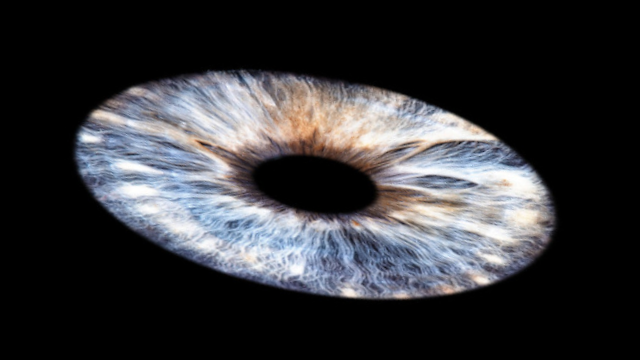

In [28]:
input_image = Image.fromarray(input_array)
display(input_image)

Let's double-check the original color image size.

In [29]:
old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))

Image size: 640x360 pixels.


## Calculate
 
We can set new dimensions for resizing.
1. Downscale factor range:  2 (by design of the resize IP)
2. Input size is 640x360 and output size of Image is 320x180 for this version of resize IP

In [30]:
new_width = int(old_width/2)
new_height = int(old_height/2)

We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `cma_array()` to perform the allocation.

In [31]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

Documentation snippet for `xlnk.cma_array`:

```python
"""
Get a contiguously allocated numpy array

Parameters
----------
shape : int or tuple of int
    The dimensions of the array to construct - We use (height, width, depth)
dtype : numpy.dtype or str
    The data type to construct - We use 8-bit unsigned int

"""
```


<img src="./images/local2shared.png" width="650" height="550"/>


We now display the image in buffer.

__Note : The `input_array` has to be copied into the contiguous memory array (deep copy).__

The input buffer size should be 640 x 360 x 3 (height x width x depth).

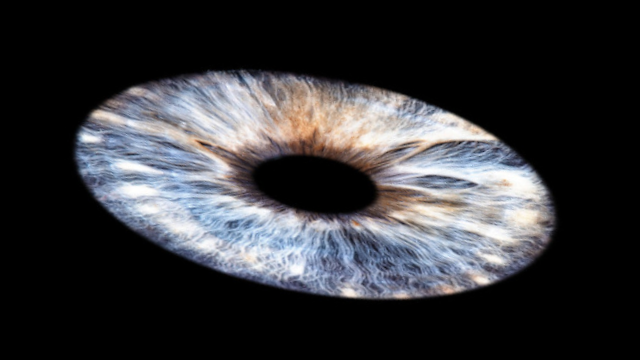

Image size: 640x360 pixels.


In [32]:
in_buffer[0:640*360*3] = input_array
buf_image = Image.fromarray(in_buffer)
display(buf_image)
print("Image size: {}x{} pixels.".format(old_width, old_height))

We can now run the resizer IP.
We will push the data from input buffer through the pipeline to the output buffer.


<img src="./images/resize_accel.png" width="650" height="550"/>


We will first need to setup moments input, output and DMA IPs using MMIO interface 
before we stream image data to them.
For example, we can write one value to MMIO registers of resizer and read three.

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | number (input extension)               |
| 0x18            | number out x center                    |
| 0x20            | number out y center                    |
| 0x28            | number out angle x componet            |
| 0x30            | number out angle y componet            |

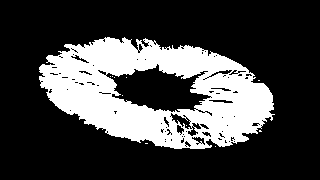

Return angle components: angle x comp: 3159 angle y comp: 1156
Return values of moments: x: 157 y: 92 angleRAD: 0.17540142501229872
Image has also been resized in Hardware(PL): 320x180 pixels.


In [37]:
moments.write(0x10, 13)
x = moments.read(0x18)
y = moments.read(0x20)
anglex = moments.read(0x28)
angley = moments.read(0x30)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    moments.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

result = Image.fromarray(out_buffer)
display(result)
angleRAD = 0.5 * math.atan2(angley,anglex)
print('Return angle components: angle x comp: {} angle y comp: {}'.format(anglex, angley))
print('Return values of moments: x: {} y: {} angleRAD: {}'.format(x,y,angleRAD))
print("Image has also been resized in Hardware(PL): {}x{} pixels.".format(new_width, new_height))

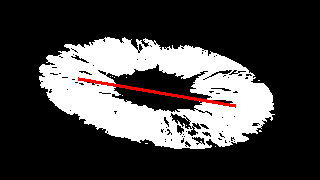

In [38]:
ll = 80
draw = ImageDraw.Draw(result)
draw.line((x-ll*np.cos(-angleRAD),y+ll*np.sin(-angleRAD),x+ll*np.cos(-angleRAD),y-ll*np.sin(-angleRAD)), fill=255, width=4)
del draw
display(result)

## We can time the moment calculator and resizing in PL operation

In [ ]:
%%timeit

moments.write(0x10, old_height)
moments.read(0x18)
moments.read(0x20)
moments.read(0x28)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    moments.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

result = Image.fromarray(out_buffer)

Finally we need to reset all the contiguous memory buffers.

In [ ]:
xlnk.xlnk_reset()

[Contents](#Contents)

# References

Image from original resizer_PL notebook, change to reflect its new behavior as moment calculator and resizer.

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   